In [17]:
import numpy as np
from bec.quantum_dot.dot import QuantumDot
from smef.core.drives.types import DriveSpec
from smef.engine import SimulationEngine, UnitSystem
from smef.core.units import Q

from bec.metrics.metrics import QDDiagnostics
from bec.quantum_dot.dot import QuantumDot
from bec.quantum_dot.enums import QDState, TransitionPair
from bec.quantum_dot.factories.drives import make_gaussian_field_drive_pi
from bec.quantum_dot.smef.initial_state import rho0_qd_vacuum
from bec.quantum_dot.spec.energy_structure import EnergyStructure
from bec.quantum_dot.spec.dipole_params import DipoleParams
from bec.quantum_dot.spec.cavity_params import CavityParams

from bec.light.classical.field_drive import ClassicalFieldDriveU
from bec.light.classical.amplitude import FieldAmplitude
from bec.light.classical.carrier import Carrier
from bec.light.envelopes.gaussian import GaussianEnvelopeU
from bec.light.core.polarization import JonesState
from bec.light.classical.carrier_profiles import constant as constant_detune

from bec.reporting.plotting.api import plot_run, plot_runs
from bec.reporting.plotting.grid import PlotConfig
from bec.metrics.metrics import QDDiagnostics


In [2]:
_SOLVE_OPTIONS = {
        "qutip_options": {
            "method": "bdf",
            "atol": 1e-10,
            "rtol": 1e-8,
            "nsteps": 200000,
            "max_step": 0.01,   # ns
            "progress_bar": "tqdm",
        }
    }

In [3]:
   

def make_qd() -> QuantumDot:
    # Old globals:
    # EXCITON = 1.300 eV
    # BINDING = 3e-3 eV
    # FSS = 5e-6 eV
    exciton = Q(1.300, "eV")
    binding = Q(3.0e-3, "eV")
    fss = Q(5.0e-6, "eV")

    energy = EnergyStructure.from_params(
        exciton=exciton,
        binding=binding,
        fss=fss,
    )

    # Old: DipoleParams(dipole_moment_Cm = 10 Debye)
    # 1 Debye = 3.33564e-30 C*m
    dipoles = DipoleParams.biexciton_cascade_from_fss(
        mu_default_Cm=Q(10.0 * 3.33564e-30, "C*m"),
        fss=fss,
    )

    # Old: CavityParams(Q=5e4, Veff_um3=0.5, lambda_nm=930.0, n=3.4)
    cavity = CavityParams.from_values(
        Q=5.0e4,
        Veff_um3=0.5,
        lambda_nm=930.0,
        n=3.4,
    )

    return QuantumDot(
        energy=energy,
        dipoles=dipoles,
        cavity=cavity,
        phonons=None,
    )


### Two-photon excitation (TPE) of the biexciton in ns units

This cell runs a minimal two-photon excitation (TPE) simulation of a four-level quantum dot (G, X1, X2, XX) using the SMEF engine with QuTiP as the backend.

Key choices:
- **Time axis in nanoseconds:** we set `time_unit_s = 1 ns`, so the solver `tlist` is directly interpreted as time in ns.
- **Resonant TPE condition:** for a two-photon drive, the laser carrier is set to  
  \(\omega_L = \frac{1}{2}\,\omega_{G\leftrightarrow XX}\),  
  so that \(2\omega_L\) matches the biexciton transition energy.
- **Gaussian \(\pi\)-pulse:** we use a Gaussian envelope centered at `t0_ns` with width `sigma_ns` (e.g. 0.05 ns = 50 ps) and set the amplitude such that the effective pulse area is \(\pi\).

Outputs:
- `res`: solver result (time grid, expectation values, and optionally states)
- `drive`: the constructed TPE drive object (used for plotting the envelope/carrier)
- `tlist`: the solver time grid in ns
- `units`: the unit system used for conversion/reporting

Finally, `plot_run(...)` produces a compact diagnostic plot showing the drive panel and the resulting QD populations (and any configured outputs).


chosen_final: [('G<->XX', '2ph', 1.0, 0.0, 0.0)]


  0%|          | 0/2000 [00:00<?, ?it/s]

QUANTUM DOT METRICS REPORT

STATE SANITY
------------------------------------------------------------------------------
Trace               : 1
Hermiticity error   : 7.85161e-17
Min eigenvalue      : -7.45112e-17

QD POPULATIONS (final state)
------------------------------------------------------------------------------
  G : 0.994564
 X1 : 0.00265572
 X2 : 0.00265572
 XX : 0.000124219

PHOTON NUMBER DECOMPOSITION (GX + XX)
------------------------------------------------------------------------------
p0        : 0.0638319
p1_total  : 0.00443971
p2_exact  : 0.911155

PHOTON NUMBER DECOMPOSITION (GX only)
------------------------------------------------------------------------------
p0        : 0.0682716
p1_total  : 0.912027
p2_exact  : 0.0197013

PHOTON NUMBER DECOMPOSITION (XX only)
------------------------------------------------------------------------------
p0        : 0.0638319
p1_total  : 0.915595
p2_exact  : 0.020573

PHOTON NUMBER EXPECTATION VALUES
----------------------------

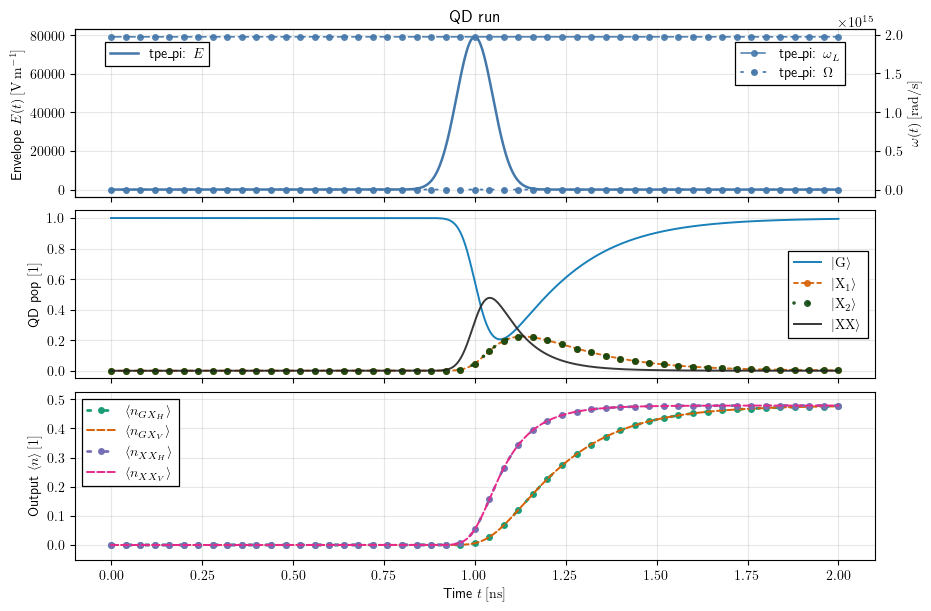

In [4]:
def run_tpe_excitation_ns(
    qd: QuantumDot,
    *,
    t_end_ns: float = 2.0,
    n_points: int = 2001,
    t0_ns: float = 1.0,
    sigma_ns: float = 0.05,   # 50 ps
):
    # 1 solver unit = 1 ns
    time_unit_s = float(Q(1.0, "ns").to("s").magnitude)
    units = UnitSystem(time_unit_s=time_unit_s)
    engine = SimulationEngine(audit=False)

    # Time axis in ns (because time_unit_s=1 ns)
    tlist = np.linspace(0.0, float(t_end_ns), int(n_points))

    bundle = qd.compile_bundle(units=units)
    dims = bundle.modes.dims()
    rho0 = rho0_qd_vacuum(dims=dims, qd_state=QDState.G)

    # Two-photon resonance: omega_L = 0.5 * omega_ref(G<->XX)
    omega_G_XX = float(qd.derived.omega_ref_rad_s(TransitionPair.G_XX))
    omega_L = 0.5 * omega_G_XX

    drive = make_gaussian_field_drive_pi(
        qd,
        pair=TransitionPair.G_XX,
        t0=Q(float(t0_ns), "ns"),
        sigma=Q(float(sigma_ns), "ns"),
        preferred_kind="2ph",
        label="tpe_pi",
        include_polaron=True,
        omega0_rad_s=omega_L,
        chirp_rate_rad_s2=None,
    )

    specs = [DriveSpec(payload=drive, drive_id=drive.label or "tpe")]



    res = engine.run(
        qd,
        tlist=tlist,
        time_unit_s=time_unit_s,
        rho0=rho0,
        drives=specs,
        solve_options=_SOLVE_OPTIONS,
    )

    return res, drive, tlist, units
qd=make_qd()
res, drive, tlist, units = run_tpe_excitation_ns(qd)
plot_run(res, units=units, drives=[drive], qd=qd);
metrics = QDDiagnostics().compute(qd, res, units=units)
print(metrics.to_text())


## Detuned two-photon excitation (constant detuning)

In this section we repeat the two-photon excitation (TPE) simulation with a **constant two-photon detuning**  
\(\Delta_{2\gamma} \neq 0\).  
The pulse envelope, amplitude, and timing are unchanged; only the **laser carrier frequency** is shifted away from the two-photon resonance.

---

### Physical picture

We consider the transition
\[
|G\rangle \;\leftrightarrow\; |XX\rangle
\]
driven via two-photon absorption.  
The resonance condition for two-photon excitation is
\[
2\omega_L = \omega_{G\to XX},
\]
where:
- \(\omega_L\) is the laser angular frequency (per photon),
- \(\omega_{G\to XX}\) is the angular frequency corresponding to the energy gap between \(|G\rangle\) and \(|XX\rangle\).

A **two-photon detuning** is defined as
\[
\Delta_{2\gamma} = 2\omega_L - \omega_{G\to XX}.
\]

---

### Detuning convention and unit conversion

In the code, the detuning is specified in **GHz**, interpreted as cycles per second.  
To convert to angular frequency, we use
\[
\Delta_{2\gamma}^{(\mathrm{rad/s})}
= 2\pi \times \Delta_{2\gamma}^{(\mathrm{GHz})} \times 10^9.
\]

Because the laser frequency enters per photon, the laser angular frequency is chosen as
\[
\omega_L
= \frac{\omega_{G\to XX}}{2}
+ \frac{\Delta_{2\gamma}^{(\mathrm{rad/s})}}{2}.
\]

With this choice,
\[
2\omega_L - \omega_{G\to XX}
= \Delta_{2\gamma}^{(\mathrm{rad/s})},
\]
so the desired two-photon detuning is reproduced exactly.

---

### Rotating-frame Hamiltonian interpretation

The SMEF/QD model is formulated in a rotating frame with the rotating-wave approximation (RWA).  
In this frame, a constant two-photon detuning produces an additional Hamiltonian term
\[
\hat{H}_{\mathrm{det}}
= -\frac{\hbar}{2}\,\Delta_{2\gamma}
\left(
|XX\rangle\langle XX| - |G\rangle\langle G|
\right).
\]

This term is automatically generated by the QD drive pipeline when the drive payload provides a laser frequency \(\omega_L(t)\).  
Only the slow detuning scale (GHz) appears in the Hamiltonian; fast optical oscillations are eliminated by the rotating frame.

---

### Pulse construction

We manually construct a `ClassicalFieldDriveU` with:
- a Gaussian temporal envelope,
- a fixed peak electric field amplitude,
- a constant carrier detuning,
- linear \(H\) polarization,
- `preferred_kind="2ph"` to ensure the decoder targets the \(G \leftrightarrow XX\) transition.

The carrier is specified as
\[
\omega_L(t) = \omega_0 + \delta\omega,
\]
where:
- \(\omega_0 = \omega_{G\to XX}/2\) is the resonant per-photon frequency,
- \(\delta\omega = \Delta_{2\gamma}/2\) is the per-photon detuning.

---


chosen_final: [('G<->XX', '2ph', 1.0, 18849555921.5, 18849555921.5)]


  0%|          | 0/2000 [00:00<?, ?it/s]

QUANTUM DOT METRICS REPORT

STATE SANITY
------------------------------------------------------------------------------
Trace               : 1
Hermiticity error   : 1.28035e-16
Min eigenvalue      : -4.77606e-18

QD POPULATIONS (final state)
------------------------------------------------------------------------------
  G : 0.997323
 X1 : 0.00130189
 X2 : 0.00130189
 XX : 7.27254e-05

PHOTON NUMBER DECOMPOSITION (GX + XX)
------------------------------------------------------------------------------
p0        : 0.48129
p1_total  : 0.00210383
p2_exact  : 0.504184

PHOTON NUMBER DECOMPOSITION (GX only)
------------------------------------------------------------------------------
p0        : 0.483394
p1_total  : 0.504684
p2_exact  : 0.0119224

PHOTON NUMBER DECOMPOSITION (XX only)
------------------------------------------------------------------------------
p0        : 0.48129
p1_total  : 0.506288
p2_exact  : 0.0124224

PHOTON NUMBER EXPECTATION VALUES
--------------------------------

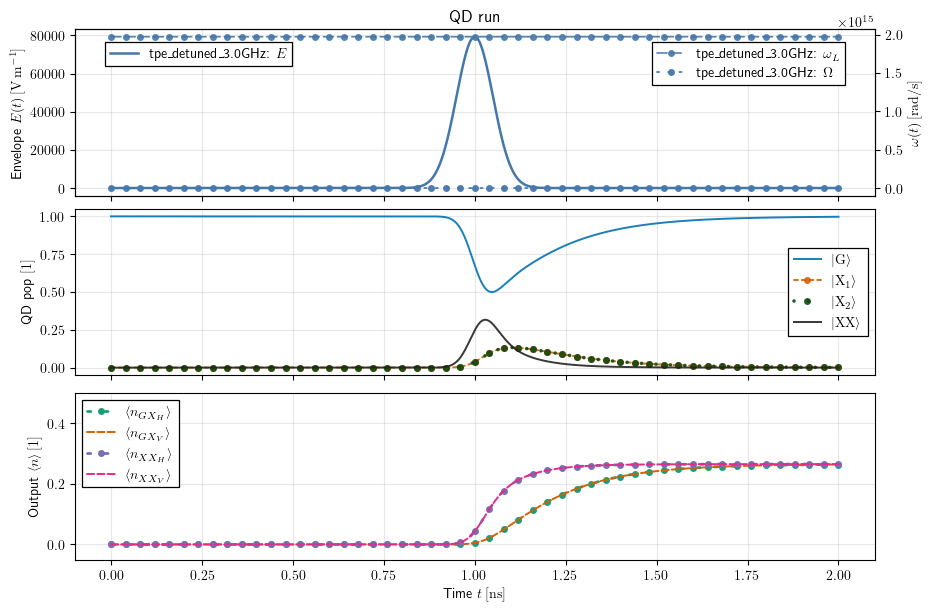

In [34]:

def run_tpe_detuned_constant_ns(
    qd: QuantumDot,
    *,
    detune_2ph_GHz: float = 3.0,   # two-photon detuning
    t_end_ns: float = 2.0,
    n_points: int = 2001,
    t0_ns: float = 1.0,
    sigma_ns: float = 0.05,        # 50 ps
):
    # 1 solver unit = 1 ns
    time_unit_s = float(Q(1.0, "ns").to("s").magnitude)
    units = UnitSystem(time_unit_s=time_unit_s)
    engine = SimulationEngine(audit=False)

    # Time grid in ns
    tlist = np.linspace(0.0, float(t_end_ns), int(n_points))

    # Initial state creation
    bundle = qd.compile_bundle(units=units)
    dims = bundle.modes.dims()
    rho0 = rho0_qd_vacuum(dims=dims, qd_state=QDState.G)


    time_unit_s = float(Q(1.0, "ns").to("s").magnitude)
    units = UnitSystem(time_unit_s=time_unit_s)
    
    omega_ref = float(qd.derived.omega_ref_rad_s(TransitionPair.G_XX))  # rad/s gap G->XX

    
    omega_L_res = 0.5 * omega_ref                                      # per-photon resonance

    # detune_2ph_GHz is TWO-PHOTON detuning in GHz (cycles/s)
    delta_2ph_rad_s = 2.0 * np.pi * detune_2ph_GHz * 1e9               # rad/s
    delta_L_rad_s = 0.5 * delta_2ph_rad_s                               # per-photon detuning

    omega0 = omega_L_res                                                # absolute laser omega (rad/s)
    # constant detuning: delta_omega(t) = delta_L_rad_s


    drive1 = ClassicalFieldDriveU(
        envelope=GaussianEnvelopeU(t0=Q(t0_ns, "ns"), sigma=Q(sigma_ns, "ns")),
        amplitude=FieldAmplitude(E0=Q(79247, "V/m")),
        carrier=Carrier(
            omega0=Q(float(omega0), "rad/s"),
            delta_omega=constant_detune(Q(float(delta_L_rad_s), "rad/s")),
            phi0=0.0,
        ),
        pol_state=JonesState.H(),
        label=f"tpe_detuned_{detune_2ph_GHz:.1f}GHz",
        preferred_kind="2ph"
    )

    #print(drive1.report_plain(time_unit_s=time_unit_s))

    specs = [DriveSpec(payload=drive1, drive_id=drive.label)]


    res = engine.run(
        qd,
        tlist=tlist,
        time_unit_s=time_unit_s,
        rho0=rho0,
        drives=specs,
        solve_options=_SOLVE_OPTIONS,
    )

    return res, drive, tlist, units
qd=make_qd()
res, drive, tlist, units = run_tpe_detuned_constant_ns(qd)
plot_run(res, units=units, drives=[drive], qd=qd);
metrics = QDDiagnostics().compute(qd, res, units=units)
print(metrics.to_text())

chosen_final: [('G<->XX', '2ph', 1.0, 0.0, 0.0)]


  0%|          | 0/2000 [00:00<?, ?it/s]

QUANTUM DOT METRICS REPORT

STATE SANITY
------------------------------------------------------------------------------
Trace               : 1
Hermiticity error   : 3.60483e-18
Min eigenvalue      : -6.64696e-17

QD POPULATIONS (final state)
------------------------------------------------------------------------------
  G : 0.986308
 X1 : 0.00400428
 X2 : 0.00400428
 XX : 0.00568328

PHOTON NUMBER DECOMPOSITION (GX + XX)
------------------------------------------------------------------------------
p0        : 0.0262131
p1_total  : 0.00415435
p2_exact  : 0.842192

PHOTON NUMBER DECOMPOSITION (GX only)
------------------------------------------------------------------------------
p0        : 0.0303674
p1_total  : 0.846046
p2_exact  : 0.123586

PHOTON NUMBER DECOMPOSITION (XX only)
------------------------------------------------------------------------------
p0        : 0.0262131
p1_total  : 0.846346
p2_exact  : 0.127441

PHOTON NUMBER EXPECTATION VALUES
------------------------------

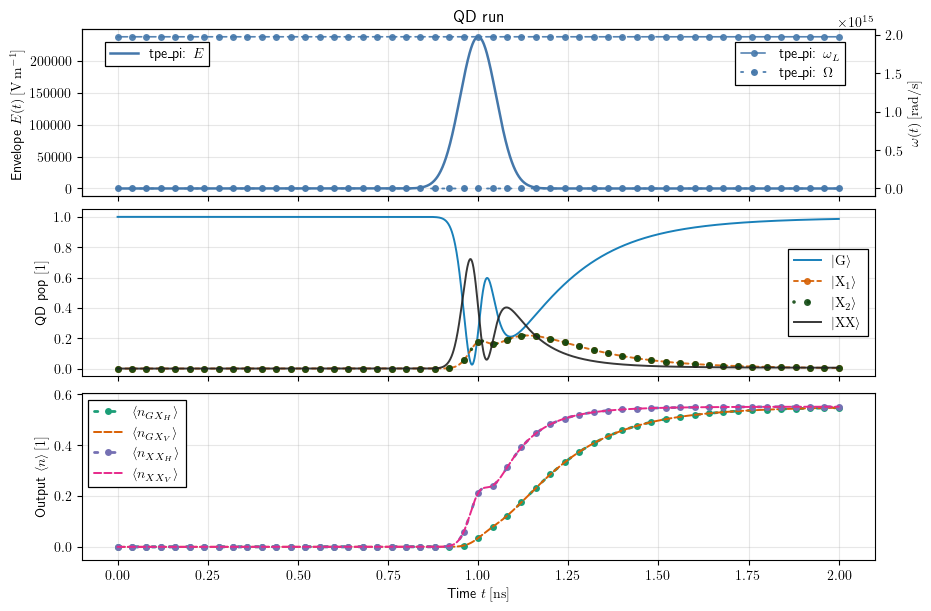

In [38]:
def run_tpe_excitation_overdrive_ns(
    qd: QuantumDot,
    *,
    t_end_ns: float = 2.0,
    n_points: int = 2001,
    t0_ns: float = 1.0,
    sigma_ns: float = 0.05,   # 50 ps
):
    # 1 solver unit = 1 ns
    time_unit_s = float(Q(1.0, "ns").to("s").magnitude)
    units = UnitSystem(time_unit_s=time_unit_s)
    engine = SimulationEngine(audit=False)

    # Time axis in ns (because time_unit_s=1 ns)
    tlist = np.linspace(0.0, float(t_end_ns), int(n_points))

    bundle = qd.compile_bundle(units=units)
    dims = bundle.modes.dims()
    rho0 = rho0_qd_vacuum(dims=dims, qd_state=QDState.G)

    # Two-photon resonance: omega_L = 0.5 * omega_ref(G<->XX)
    omega_G_XX = float(qd.derived.omega_ref_rad_s(TransitionPair.G_XX))
    omega_L = 0.5 * omega_G_XX

    sigma5_ns = 3.0 * float(sigma_ns)
    amp_scale = 3
    drive = make_gaussian_field_drive_pi(
        qd,
        pair=TransitionPair.G_XX,
        t0=Q(float(t0_ns), "ns"),
        sigma=Q(float(sigma_ns), "ns"),
        preferred_kind="2ph",
        label="tpe_pi",
        include_polaron=True,
        omega0_rad_s=omega_L,
        chirp_rate_rad_s2=None,
    ).scaled(amp_scale)
    #drive = drive.scaled(5.0)

    specs = [DriveSpec(payload=drive, drive_id=drive.label or "tpe")]



    res = engine.run(
        qd,
        tlist=tlist,
        time_unit_s=time_unit_s,
        rho0=rho0,
        drives=specs,
        solve_options=_SOLVE_OPTIONS,
    )

    return res, drive, tlist, units
qd=make_qd()

res, drive, tlist, units = run_tpe_excitation_overdrive_ns(qd)

plot_run(res, units=units, drives=[drive], qd=qd);
metrics = QDDiagnostics().compute(qd, res, units=units)
print(metrics.to_text())
